In [24]:
import kwant
import matplotlib.pyplot as plt
import meanfi
import numpy as np
from scipy.spatial import Delaunay, delaunay_plot_2d
from meanfi.kwant_helper import utils

s0 = np.identity(2)
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sz = np.diag([1, -1])

# Create graphene latticetif file
graphene = kwant.lattice.general(
    [(1, 0), (1 / 2, np.sqrt(3) / 2)], [(0, 0), (0, 1 / np.sqrt(3))], norbs=2
)
a, b = graphene.sublattices

# Create bulk system
bulk_graphene = kwant.Builder(kwant.TranslationalSymmetry(*graphene.prim_vecs))
# Set onsite energy to zero
bulk_graphene[a.shape((lambda pos: True), (0, 0))] = 0 * s0
bulk_graphene[b.shape((lambda pos: True), (0, 0))] = 0 * s0
# Add hoppings between sublattices
bulk_graphene[graphene.neighbors(1)] = s0
h_0 = utils.builder_to_tb(bulk_graphene)

In [25]:
def to_bloch(h):
    def ham(k):
        bloch_ham = sum(
            h[vector] * np.exp(1j * np.dot(k, np.array(vector)))
            for vector in h.keys()
        )
        return bloch_ham
    return ham

def polygon_area_shoelace(polygon):
    """
    Compute the polygon area via the shoelace formula.
    polygon: (N,2) array of vertices in an order that encloses the polygon.
    """
    x = polygon[:, 0]
    y = polygon[:, 1]
    # Roll arrays by one for the cross terms
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

def fermi_energy_custom_grid(evals, weights, filling):
    """
    Find Fermi energy given band energies and k-point weights for a custom grid.

    Parameters
    ----------
    evals : array-like of shape (Nk, nbands)
        Eigenvalues at the center of each polygon.
    weights : array-like of shape (Nk,)
        Weights for each area of a polygon. Must sum to 1.
    filling : float
        Desired filling (in 'number of electrons per unit cell').

    Returns
    -------
    fermi : float
        Estimated Fermi energy for the given filling.
    """

    # Flatten all eigenvalues with their corresponding weights
    # We'll store them in a list of (energy, weight) pairs.
    # The total weight is the sum of weights for each band at each k.
    # Because each k has weight w_k, each band at k carries that same weight w_k.
    
    Nk, nbands = evals.shape
    energy_weight_pairs = []
    for ik in range(Nk):
        w_k = weights[ik]
        for b in range(nbands):
            energy_weight_pairs.append((evals[ik, b], w_k))
    
    # Sort by energy ascending
    energy_weight_pairs.sort(key=lambda x: x[0])  # sort by the first element (energy)
    
    # Now accumulate until we reach the desired filling
    accumulated = 0.0
    fermi = energy_weight_pairs[-1][0]  # default to highest if we fill all
    for ifermi, (E, w) in enumerate(energy_weight_pairs):
        accumulated += w
        if accumulated >= filling:
            w_over = accumulated - filling
            w_under = w - w_over
            fermi = (1 - w_under / w) * energy_weight_pairs[ifermi-1][0] + w_under / w * E
            break
    return fermi

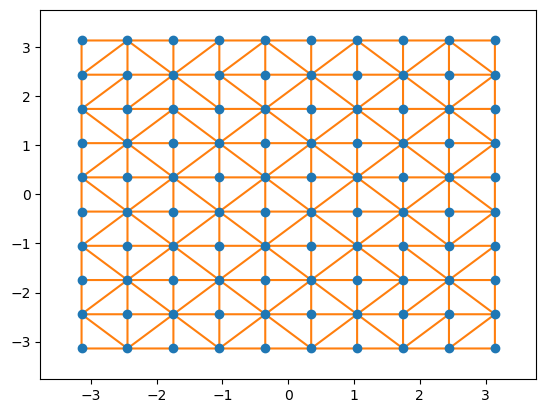

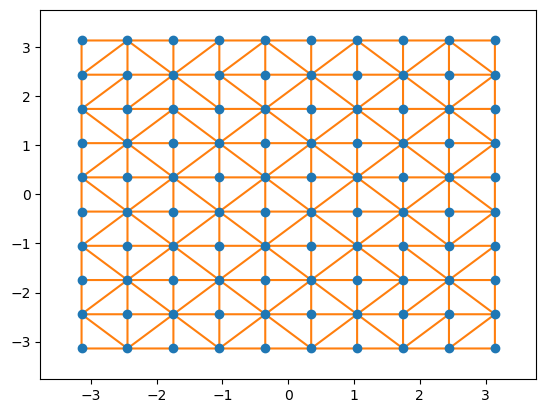

In [49]:
# test on a square grid case

def build_kmesh(Nkx, Nky, kx_bounds=(-np.pi, np.pi), ky_bounds=(-np.pi, np.pi)):
    """
    Returns an array of shape (Nk, 2) with (kx, ky) points in a 2D grid.
    """
    kx_vals = np.linspace(kx_bounds[0], kx_bounds[1], Nkx)
    ky_vals = np.linspace(ky_bounds[0], ky_bounds[1], Nky)
    kpoints = np.array([[kx, ky] for kx in kx_vals for ky in ky_vals])
    return kpoints

nk = 10
filling = 1.7

h_k = to_bloch(h_0)
ks = build_kmesh(nk, nk)
h_ks = np.array([h_k(k) for k in ks])
evals = np.linalg.eigvalsh(h_ks)

# triagulate the k-points
mesh = Delaunay(ks)
areas = np.array([polygon_area_shoelace(ks[simplex]) for simplex in mesh.simplices])
# now I need to find the interpolated evals at the center of each triangle.
# it might make more sense to just evaluate them there in the first place, but let's do it this way for now.
simplex_evals = np.array([evals[simplex] for simplex in mesh.simplices])
simplex_evals = np.mean(simplex_evals, axis=1)
# Compute the weights of each k-point
weights = areas / sum(areas)

delaunay_plot_2d(mesh)

In [50]:
np.abs(meanfi.fermi_energy(h_0, filling, nk=nk) - fermi_energy_custom_grid(simplex_evals, weights, filling))

np.float64(0.15597037125401458)